# Zone Temperature Dynamical Model

Goals:
- investigate different physics-informed dynamical models for zone temperature prediction
- thermal dynamics should be captured

In [29]:
from jax import config 
config.update("jax_debug_nans", False)
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

import jax 
import jax.numpy as jnp 
import flax.linen as nn
import optax 
import pandas as pd 

from dynax.core.base_block_state_space import BaseContinuousBlockSSM
from dynax.simulators.simulator import DifferentiableSimulator
from dynax.trainer.train_state import TrainState

# need use double precision for numerical stability to training some networks
#jax.config.update("jax_enable_x64", True)

## 0. Data and DataLoader
- EP data with prototypical building model
- Real data from Lennox thermostat data

In [30]:
"""
import pandas as pd 

dates = ['01-'+str(i)+'-18' for i in range(14, 28)]
data = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)

combined_data = pd.DataFrame()
for key in data.keys():
    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)

combined_data.to_csv('./data/real-world-data.csv')
"""

"\nimport pandas as pd \n\ndates = ['01-'+str(i)+'-18' for i in range(14, 28)]\ndata = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)\n\ncombined_data = pd.DataFrame()\nfor key in data.keys():\n    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)\n\ncombined_data.to_csv('./data/real-world-data.csv')\n"

In [31]:
data = pd.read_csv('./data/real-world-data.csv')

columns_mapper = {'LocalTime':'time', 'tabtsense0':'temp_zone', 'SP_cool':'csp', 'SP_heat':'hsp', 'CoolDemand':'qcool', 'HeatDemand':'qheat', 'humidityindoor_0':'rh_zone', 'oupresentcompressorfreq':'freq', 'iuairflowrate':'cfm', 'surf_tempf':'temp_out', 'rad':'qsol'}

data = data[columns_mapper.keys()].rename(columns = columns_mapper)
data.index = pd.DatetimeIndex(data['time'], freq='1min')
data = data.drop(columns=['time'])


In [32]:
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol
time,,,,,,,,,,
2018-01-14 18:01:00,69.6,77,70,0,100,35.5,NaN,0,41.531667,0.0
2018-01-14 18:02:00,69.5,77,70,0,100,36.0,NaN,0,41.563333,0.0
2018-01-14 18:03:00,69.5,77,70,0,100,36.0,NaN,0,41.595000,0.0
2018-01-14 18:04:00,69.6,77,70,0,100,36.0,NaN,0,41.626667,0.0
2018-01-14 18:05:00,69.6,77,70,0,100,36.0,NaN,0,41.658333,0.0


This data is from Rohini's house, which has a Lennox thermostat but Carrier unit. Thus the equipment info are basically not available. 
- assume nominal heating capacity is 4 ton (e.g., 14 kW)

In [33]:
# change IP unit to SI
# F to C
data[['temp_zone', 'csp', 'hsp', 'temp_out']] =  5./9*(data[['temp_zone', 'csp', 'hsp', 'temp_out']] - 32)
# W to kW
data['qsol'] /= 1000.
# percentage to kW
data[['qcool', 'qheat']] *= 14./100.

data['qhvac'] = -1*data['qcool'] + data['qheat']

In [34]:
# resampel to 15min 
data = data.resample('15min').mean()
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol,qhvac
time,,,,,,,,,,,
2018-01-14 18:00:00,21.206349,25.0,21.111111,0.0,7.0,35.178571,NaN,0.0,5.409722,0.0,7.0
2018-01-14 18:15:00,21.618519,25.0,21.111111,0.0,0.0,33.733333,NaN,0.0,5.664815,0.0,0.0
2018-01-14 18:30:00,21.329630,25.0,21.111111,0.0,0.0,35.333333,NaN,0.0,5.928704,0.0,0.0
2018-01-14 18:45:00,21.125926,25.0,21.111111,0.0,0.0,36.000000,NaN,0.0,6.192593,0.0,0.0
2018-01-14 19:00:00,21.118519,25.0,21.111111,0.0,0.0,36.333333,NaN,0.0,6.268519,0.0,0.0


In [35]:
# time features
def add_time_features(data):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    return data

# use cos and sin to encode cyclical features
def encode_cyclical(data, col, max_val):
    data[col+'_sin'] = np.sin(2*np.pi*data[col]/max_val)
    data[col+'_cos'] = np.cos(2*np.pi*data[col]/max_val)
    return data


In [36]:
target = ["temp_zone"]
outdoor = ["temp_out", "qsol"]
control = ["qhvac"]
feature = target + outdoor + control

data = data[feature]

# add time features
data = add_time_features(data)
data = encode_cyclical(data, "hour", 23)
data = encode_cyclical(data, "dayofweek", 6)
time_feature = ["hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos"]

data = data[feature + time_feature]
data.head()

,temp_zone,temp_out,qsol,qhvac,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
time,,,,,,,,
2018-01-14 18:00:00,21.206349,5.409722,0.0,7.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:15:00,21.618519,5.664815,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:30:00,21.329630,5.928704,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:45:00,21.125926,6.192593,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 19:00:00,21.118519,6.268519,0.0,0.0,-0.887885,0.460065,-2.449294e-16,1.0


## 1. Data Split

In [37]:
data.head()

,temp_zone,temp_out,qsol,qhvac,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
time,,,,,,,,
2018-01-14 18:00:00,21.206349,5.409722,0.0,7.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:15:00,21.618519,5.664815,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:30:00,21.329630,5.928704,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:45:00,21.125926,6.192593,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 19:00:00,21.118519,6.268519,0.0,0.0,-0.887885,0.460065,-2.449294e-16,1.0


#### Prepare Data

In [38]:
# get window data
def get_batch_data_at(batch_index, data_df, n_lags, n_future, encoder_features, decoder_features, target_col):
    encoder_inputs = data_df.iloc[batch_index-n_lags:batch_index][encoder_features].values
    decoder_inputs = data_df.iloc[batch_index:batch_index+n_future][decoder_features].values 
    target = data_df.iloc[batch_index:batch_index+n_future][target_col].values

    return encoder_inputs, decoder_inputs, target

# get batched data
def get_batch_data(idx, data_df, n_lags, n_future, encoder_features, decoder_features, target_col):
    encoder_inputs = []
    decoder_inputs = []
    targets = []
    for i in idx:
        ei, di, t = get_batch_data_at(i, data_df, n_lags, n_future, encoder_features, decoder_features, target_col)
        encoder_inputs.append(ei)
        decoder_inputs.append(di)
        targets.append(t)
    return np.array(encoder_inputs), np.array(decoder_inputs), np.array(targets)


data2 = data.copy()

# data processing parameters
n_lags = 1
n_futures = 1

split_ratio = [0.7, 0.15, 0.15]
n_samples = data.shape[0]
n_train = int(n_samples * split_ratio[0])
n_val = int(n_samples * split_ratio[1])
n_test = n_samples - n_train - n_val

# get data
state_features = ["temp_zone"]
feature = ["temp_out", "qsol", "qhvac"]
time_feature = ["hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos"]
input_features = time_feature + feature
target = ['temp_zone']

# data format
# state: (B, Nx)
# inputs: (B, T, Ni)
# outputs: (B, T, No)
# generate training data
batch_index_train = np.arange(n_lags, n_train-n_futures)
state_train, inputs_train, target_train = get_batch_data(batch_index_train, data2, n_lags, n_futures, state_features, input_features, target)
state_train = state_train.squeeze(axis=-2) # (B, 1, Nx) -> (B, Nx)

# generate validation data
batch_index_val = np.arange(n_train+n_lags, n_train+n_val-n_futures)
state_val, inputs_val, target_val = get_batch_data(batch_index_val, data2, n_lags, n_futures, state_features, input_features, target)
state_val = state_val.squeeze(axis=-2) # (B, 1, Nx) -> (B, Nx)

# generate testing data
batch_index_test = np.arange(n_train+n_val+n_lags, n_samples-n_futures)
state_test, inputs_test, target_test = get_batch_data(batch_index_test, data2, n_lags, n_futures, state_features, input_features, target)
state_test = state_test.squeeze(axis=-2) # (B, 1, Nx) -> (B, Nx)

normalize = False
if normalize:
    # normalize data
    state_mean = state_train.mean(axis=0)
    state_std = state_train.std(axis=0)
    inputs_mean = inputs_train.mean(axis=0)
    inputs_std = inputs_train.std(axis=0)
    target_mean = target_train.mean(axis=0)
    target_std = target_train.std(axis=0)

    state_train = (state_train - state_mean)/state_std
    inputs_train = (inputs_train - inputs_mean)/inputs_std
    target_train = (target_train - target_mean)/target_std

    state_val = (state_val - state_mean)/state_std
    inputs_val = (inputs_val - inputs_mean)/inputs_std
    target_val = (target_val - target_mean)/target_std

    state_test = (state_test - state_mean)/state_std
    inputs_test = (inputs_test - inputs_mean)/inputs_std
    target_test = (target_test - target_mean)/target_std

# define denormalize function
def denormalize(X, mean, std):
    return X*std + mean

In [39]:
print(state_train.shape, inputs_train.shape, target_train.shape)
print(state_val.shape, inputs_val.shape, target_val.shape)
print(state_test.shape, inputs_test.shape, target_test.shape)

(871, 1) (871, 1, 7) (871, 1, 1)
(185, 1) (185, 1, 7) (185, 1, 1)
(186, 1) (186, 1, 7) (186, 1, 1)


## 2. Models

Try two different mdoels
- lumped single zone dynamic model 
- neural ode


### 2.1 Baseline
Just use previous time step as prediction


In [40]:
def mse(y_true, y_pred):
    return jnp.mean(jnp.square(y_true - y_pred))


y_pred = state_test 
loss = mse(target_test.squeeze(), state_test.squeeze())
loss

Array(0.03949953, dtype=float32)

### 1.2 Neural ODE

For realistic settings, here I only assume known measurements, such as outdoor air temperature, solar radiation, and energy usage

$$
    \frac{dT_z}{dt} = f(h_t, T_o, \dot q_{sol}, \dot q_{hvac}; \theta)
$$

#### Define Model

In [41]:
configs = {"state_dim": 1, 
           "input_dim": 7, 
           "output_dim": 1
        }

# TODO: use einsum for batched ODE solving
# Dynamical ODE should not support batched inputs, batching will be done using vmap()
# Dynamical ODE should not support multiple time steps, rollout will be done using simulator
class NeuralODE(BaseContinuousBlockSSM):
    state_dim: int = configs["state_dim"]
    input_dim: int = configs["input_dim"]
    output_dim: int = configs["output_dim"]

    def setup(self):
        super().setup()
        self._fx = self.fx(output_dim = self.state_dim)
        self._fy = self.fy(output_dim = self.output_dim)
    
    def __call__(self, states, inputs):
        # states: (B, nx)
        # inputs: (B, ni)
        assert self.input_dim == jnp.shape(inputs)[-1]
        return super().__call__(states, inputs)

    class fx(nn.Module):
        output_dim: int 
        def setup(self):
            # use for GRU cells
            self.gru = [nn.GRUCell(features=1) for _ in range(8)]
            self.dense1 = nn.Dense(features=4)
            #self.dense2 = nn.Dense(features=4, use_bias=False)
            self.dense = nn.Dense(features=self.output_dim)
        
        def __call__(self, states, inputs):
            # combine statse and inputs
            #inputs = jnp.concatenate([states, inputs], axis=-1)
            # concatenate gru outputs
            inputs = [gru(states, inputs)[0] for gru in self.gru]
            inputs = jnp.concatenate(inputs, axis=-1)

            inputs = self.dense1(inputs)
            #inputs = nn.relu(inputs)
            #inputs = self.dense2(inputs)
            out = self.dense(inputs)
            #out = nn.relu(out)
            #out = self.dense(out)
            return out

    
    class fy(nn.Module):
        output_dim: int 

        def __call__(self, states, inputs):
            # a faked value
            return states

STATE_DIM = configs["state_dim"]
INPUT_DIM = configs["input_dim"]
ode = NeuralODE(state_dim = STATE_DIM)
key = jax.random.PRNGKey(2023)
init_params = ode.init(key, jnp.ones((STATE_DIM,)), jnp.ones((INPUT_DIM,)))
rhs, out = ode.apply(init_params, jnp.ones((STATE_DIM,)), jnp.ones((INPUT_DIM,)))
print(ode.tabulate(key, jnp.ones((STATE_DIM,)), jnp.ones((INPUT_DIM,))))
out.shape


                               NeuralODE Summary                                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ path         ┃ module    ┃ inputs       ┃ outputs      ┃ params              ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│              │ NeuralODE │ - float32[1] │ - float32[1] │                     │
│              │           │ - float32[7] │ - float32[1] │                     │
├──────────────┼───────────┼──────────────┼──────────────┼─────────────────────┤
│ _fx          │ fx        │ - float32[1] │ float32[1]   │                     │
│              │           │ - float32[7] │              │                     │
├──────────────┼───────────┼──────────────┼──────────────┼─────────────────────┤
│ _fx/gru_0    │ GRUCell   │ - float32[1] │ - float32[1] │                     │
│              │           │ - float32[7] │ - float32[1] │                     │
├──────────────┼───────────

(1,)

In [42]:
class NeuralModel(nn.Module):
    
    state_dim: int = configs["state_dim"]
    ts: int = 0
    dt: int = 900

    @nn.compact 
    def __call__(self, states, inputs):
        """
        params:
            states: (Nx,)
            inputs: (T, Ni)
        return:
            states: (T, Nx)
        """
        dynamics = NeuralODE(state_dim = self.state_dim)
        states_out, measures_out = DifferentiableSimulator(
            dynamics, 
            dt=self.dt, 
            mode_interp='linear', 
            start_time=self.ts
        )(states, inputs)
        
        return states_out

model = NeuralModel(state_dim=STATE_DIM)

key = jax.random.PRNGKey(2000)
init_params = model.init(key, jnp.ones((STATE_DIM,)), jnp.ones((1, INPUT_DIM)))
init_out = model.apply(init_params, jnp.ones((STATE_DIM,)), jnp.ones((1, INPUT_DIM)))
print(model.tabulate(key, jnp.ones((STATE_DIM,)), jnp.ones((1, INPUT_DIM))))
init_out.shape


                              NeuralModel Summary                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ NeuralModel   │ - float32[1]  │ float32[1,1] │               │
│               │               │ -             │              │               │
│               │               │ float32[1,7]  │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ Differentiab… │ Differentiab… │ - float32[1]  │ -            │               │
│               │               │ -             │ float32[1,1] │               │
│               │               │ float32[1,7]  │ -            │               │
│               │               │               │ float32[1,1] │               │
├───────────────┼──────────

(1, 1)

In [43]:
# batch Model with shared parameters
VModel = nn.vmap(NeuralModel, in_axes=(0,0), out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})
vmodel = VModel(state_dim=STATE_DIM)
init_params = vmodel.init(key, jnp.ones((32,STATE_DIM)), jnp.ones((32,4,INPUT_DIM)))
out = vmodel.apply(init_params, jnp.ones((32,STATE_DIM)), jnp.ones((32,4,INPUT_DIM)))
print(out.shape)

(32, 4, 1)


#### Training and Evaluation

In [44]:
# inverse simulation train_step
@jax.jit
def train_step(train_state, state_prev, inputs, target):
    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(params, state_prev, inputs)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state


@jax.jit
def test_step(train_state, state_prev, inputs, target):
    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(params, state_prev, inputs)
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss = mse_loss(train_state.params)


    return loss

schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 10000, 
    transition_begin=5000, 
    end_value=1e-3
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-02),
    optax.adamw(schedule)
)


In [45]:
train_state = TrainState.create(
    apply_fn=vmodel.apply,
    params=init_params,
    tx = optim,
)


In [46]:
outputs_pred = train_state.apply_fn(train_state.params, state_train, inputs_train)

In [47]:
outputs_pred.shape, inputs_train.shape, state_train.shape

((871, 1, 1), (871, 1, 7), (871, 1))

In [48]:
# check if there is nan
pred_loss = jnp.mean((outputs_pred - target_train)**2)
pred_loss

Array(88666808., dtype=float32)

In [49]:
n_epochs = 5000

# train loop
steps = []
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, state_train, inputs_train, target_train)
    if epoch % 1000 == 0:
        val_loss = test_step(train_state, state_val, inputs_val, target_val)
        test_loss = test_step(train_state, state_test, inputs_test, target_test)
        print(f"epoch: {epoch}, train loss: {loss}, val loss: {val_loss}, test loss: {test_loss}")
    
    # save for plot
    steps.append(epoch)
    train_losses.append(loss)
    val_losses.append(val_loss)


epoch: 0, train loss: 88666808.0, val loss: 81799200.0, test loss: 86055488.0
epoch: 1000, train loss: 44.102840423583984, val loss: 16.615232467651367, test loss: 5.39016580581665
epoch: 2000, train loss: 13.961068153381348, val loss: 3.5379836559295654, test loss: 1.681837558746338
epoch: 3000, train loss: 2.2765426635742188, val loss: 0.5526033043861389, test loss: 0.26283469796180725
epoch: 4000, train loss: 0.15940679609775543, val loss: 0.06994263827800751, test loss: 0.037753209471702576


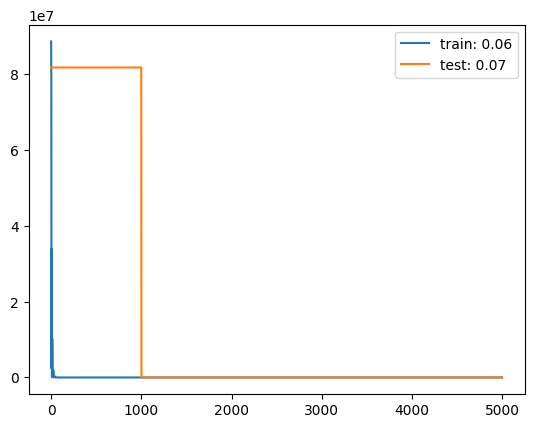

In [50]:
# plot loss
result_folder = f'./models/m2-neural-ode-single-step/ph={n_futures}/'
plt.figure()
plt.plot(steps[-10000:], train_losses[-10000:], label=f"train: {train_losses[-1]:.2f}")
plt.plot(steps[-10000:], val_losses[-10000:], label=f"test: {val_losses[-1]:.2f}")
plt.ylim([0, 1])
plt.legend()
plt.savefig(result_folder + "loss.png")

In [51]:
y_pred = vmodel.apply(train_state.params, state_train, inputs_train)
y_pred_test = vmodel.apply(train_state.params, state_test, inputs_test)

In [52]:
y_pred.shape

(871, 1, 1)

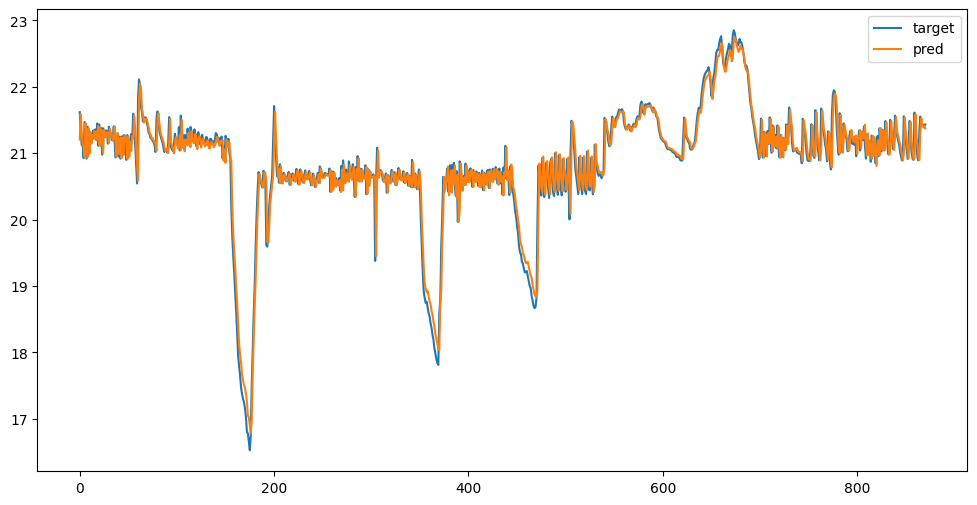

In [53]:
plt.figure(figsize=(12,6))
plt.plot(target_train[:,0,0], label='target')
plt.plot(y_pred[:,0,0], label='pred')
plt.legend()

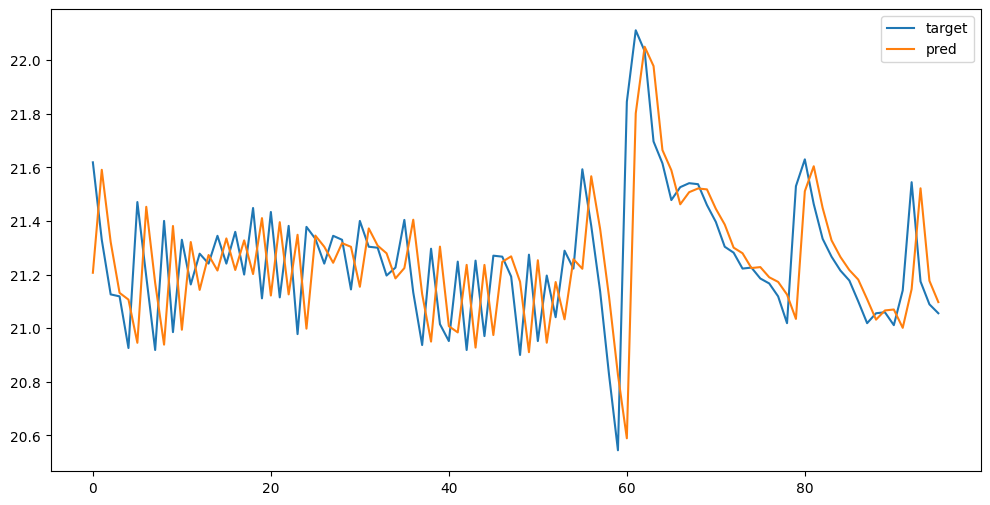

In [54]:
plt.figure(figsize=(12,6))
plt.plot(target_train[:96,0], label='target')
plt.plot(y_pred[:96,0], label='pred')
plt.legend()

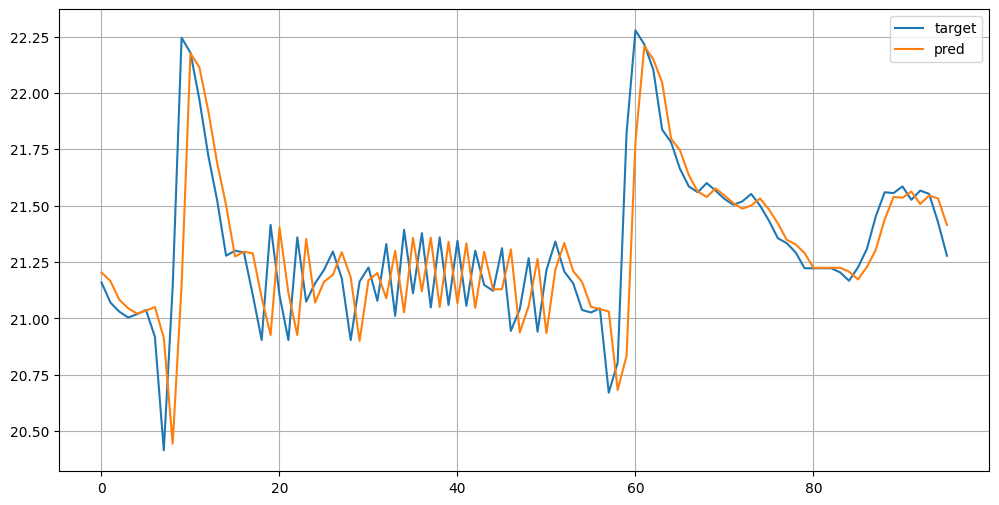

In [55]:
plt.figure(figsize=(12,6))
plt.plot(target_test[:96,0], label='target')
plt.plot(y_pred_test[:96,0], label='pred')
plt.grid()
plt.legend()

Multi-step predictions

In [56]:
horizon = 96 #target_test.shape[0]

# recursively predict future using auto-regressive approach
y_pred_horizon = []
target_horizon = []
num_samples = target_test.shape[0]
for t in range(num_samples - horizon + 1):
    y_pred_future = []
    target_future = []
    
    state_prev = state_test[[t]] # (1, Nx)
    for h in range(horizon):
        state_next = vmodel.apply(train_state.params, state_prev, inputs_test[[t+h]])
        # save for plot
        y_pred_future.append(state_next)
        target_future.append(target_test[[t+h]])
        # update
        state_prev = state_next[:, 0, :]

    y_pred_future = jnp.concatenate(y_pred_future, axis=0)
    target_future = jnp.concatenate(target_future, axis=0)

    y_pred_horizon.append(y_pred_future)
    target_horizon.append(target_future)

y_pred_horizon = jnp.stack(y_pred_horizon, axis=0)
target_horizon = jnp.stack(target_horizon, axis=0)

print(y_pred_horizon.shape)
print("ph={}: test mse is {}".format(horizon, jnp.mean((y_pred_horizon - target_horizon)**2)))

(91, 96, 1, 1)
ph=96: test mse is 0.08288098126649857


In [ ]:
target_horizon.shape, y_pred_horizon.shape

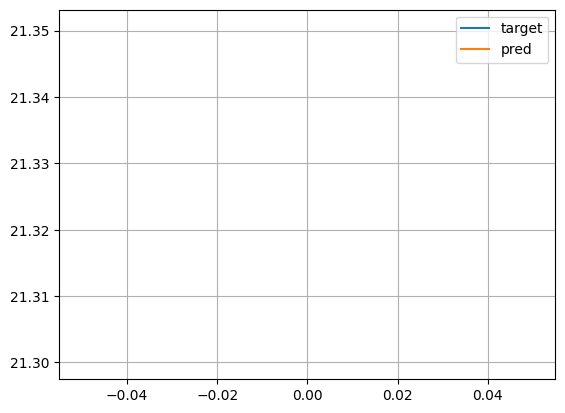

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
# draw plots from random step
step = 15
plt.figure()
plt.plot(target_horizon.squeeze()[step, :horizon], label='target')
plt.plot(y_pred_horizon.squeeze()[step, :horizon], label='pred')
plt.grid()
plt.legend()
plt.savefig(result_folder + "pred_"+str(step)+".png")


## Physics-Consistent Check

How to know if the learned model follows general physics? 
- the derivative of room temp with respect to the HVAC energy rate should be positive. The more heat injected to the room, the higher the room temperature.

In [58]:
# state: (B, Nx)
# inputs: (B, T, Ni)
state_fake = state_train[[100], ::]
inputs_fake = inputs_train[[100], ::]


In [59]:
state_fake.shape, inputs_fake.shape

((1, 1), (1, 1, 7))

In [60]:
inputs_fake[:, :, -1]

array([[0.93333333]])

In [61]:
#create 10 different points: 0-10 kW
q_hvac = np.array([i for i in range(-10, 10)])
n_points = len(q_hvac)

others = np.tile(inputs_fake[:,:,:-1], reps=(n_points, 1, 1))
q_hvac = q_hvac.reshape(-1,1)[:, np.newaxis, :]
q_hvac = np.tile(q_hvac, reps=(1, inputs_fake.shape[1], 1))
q_hvac.shape, others.shape

((20, 1, 1), (20, 1, 6))

In [62]:
state = np.tile(state_fake, reps=(n_points, 1))
inputs = np.concatenate([others, q_hvac], axis=-1)
state.shape, inputs.shape

((20, 1), (20, 1, 7))

In [63]:
y_pred = vmodel.apply(train_state.params, state, inputs)
y_pred.shape

(20, 1, 1)

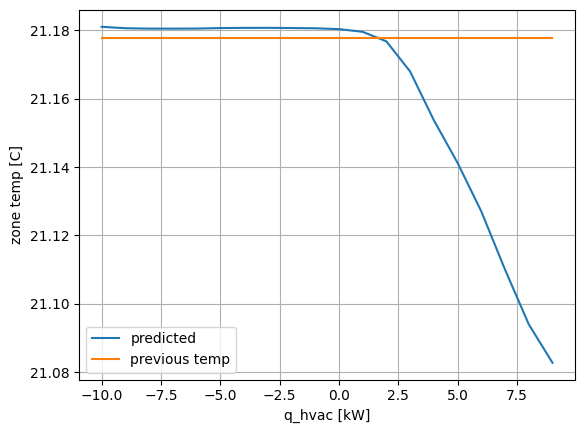

In [64]:
time = 0

plt.figure()
plt.plot(q_hvac[:, time, :], y_pred[:, time, :], label='predicted') #
plt.plot(q_hvac[:, time, :], state, label='previous temp') # previous temperature
plt.legend()
plt.grid()
plt.xlabel('q_hvac [kW]')
plt.ylabel('zone temp [C]')
plt.savefig(result_folder + "physics-consistency.png")